In [0]:
#Import packages
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, date_trunc, max as max_
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import TimestampType
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone
import pytz
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from distutils.version import LooseVersion
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from itertools import chain
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

sqlContext = SQLContext(sc)

# Define Functions

In [0]:
def pipeline_helper(categoricalColumns, numericCols):
    """Helper function to create pipeline for preparing data for modeling"""
    stages = [] # stages in our Pipeline

    for categoricalCol in categoricalColumns:
        # Category Indexing with StringIndexer
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid='keep')
        # Add stages.  These are not run here, but will run all at once later on.
        stages += [stringIndexer]
        
    # Convert label into label indices using the StringIndexer
    label_stringIdx = StringIndexer(inputCol="DELAY", outputCol="label", handleInvalid="keep")
    stages += [label_stringIdx]
    
    # Transform all features into a vector using VectorAssembler
    assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='keep')
    stages += [assembler]
    
    partialPipeline = Pipeline().setStages(stages)

    return partialPipeline

In [0]:
def pipeline_fit_transform(partialPipeline, train_data, validation_data):
    """Helper function to fit and transform training data and then transform validation data. Outputs transformed training and validation datasets."""
    #Fit the pipeline to the train data
    pipelineModel = partialPipeline.fit(train_data)

    #Transform the training data
    preppedDataDF_training = pipelineModel.transform(train_data)
    
    #Use the pipeline to transform the validation data
    preppedDataDF_validation = pipelineModel.transform(validation_data)
    
    return preppedDataDF_training, preppedDataDF_validation

In [0]:
def class_weights_helper(training_dataset):
    """Helper function to calculate class weights and add to data to account for imbalance in labels in training data."""
    #Get size of training set
    train_size = float(training_dataset.select("DELAY").count())

    #Get count of flights with delay in the training set (this is the class with fewer)
    numPositives = training_dataset.select("DELAY").where('DELAY==1').count()
    BalancingRatio = numPositives / train_size
    
    #Create a new column named classWeights in the training dataset
    training_dataset_updated = training_dataset.withColumn("classWeights", when(training_dataset.DELAY == 0, BalancingRatio).otherwise(1-BalancingRatio))
    
    return training_dataset_updated

In [0]:
def display_metrics(predictionsVar):
    """Helper function to display model metrics and Confusion matrix"""
    
    #Calculate AUC
    evaluator = BinaryClassificationEvaluator()
    AUC = evaluator.evaluate(predictionsVar)
    
    # compute TN, TP, FN, and FP
    #predictionsVar.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = predictionsVar.filter('prediction = 0 AND label = prediction').count()
    TP = predictionsVar.filter('prediction = 1 AND label = prediction').count()
    FN = predictionsVar.filter('prediction = 0 AND label <> prediction').count()
    FP = predictionsVar.filter('prediction = 1 AND label <> prediction').count()

    # calculate accuracy, precision, recall, and F1-score
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)

    print('AUC: %0.3f' % AUC)
    print('precision: %0.3f' % precision)
    print('recall: %0.3f' % recall)
    print('accuracy: %0.3f' % accuracy)
    print('F1 score: %0.3f' % F)

    #Display Confusion Matrix
    cf_matrix = np.array([[TN, FP],[FN, TP]])

    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:,}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
               zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    categories = ['No Delay', 'Delay']
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = categories, yticklabels = categories)

In [0]:
# Define function to view features with their names
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    """Helper function to get feature importances."""
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

# Read Data

In [0]:
#Read data

#3 MONTH
filename = "train_data_3m"                      
train_data_3m = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

filename = "validation_data_3m"                      
validation_data_3m = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

#FULL
filename = "train_data"                      
train_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

filename = "validation_data"                      
validation_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

filename = "test_data"                      
test_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

# Random Forest Model (on 3 month data)

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "VIS_VAR"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS']

pipelineOutput_rf = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_rf, validation_dataset_rf = pipeline_fit_transform(pipelineOutput_rf, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_rf_ww = class_weights_helper(train_dataset_rf)

In [0]:
#Cache prepared datasets
train_dataset_rf_ww.cache()
validation_dataset_rf.cache()

Out[77]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, VIS_VARIndex: double, label: double, features: vector]

In [0]:
# Create an initial RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxBins=300)

# Train model with Training Data
rfModel = rf.fit(train_dataset_rf_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_rf = rfModel.transform(validation_dataset_rf)

AUC: 0.669
precision: 0.310
recall: 0.570
accuracy: 0.642
F1 score: 0.402

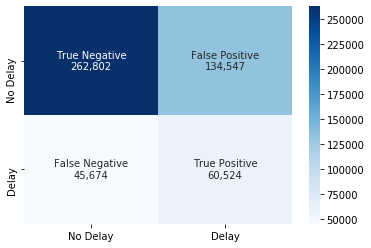

In [0]:
display_metrics(predictions_rf)

In [0]:
#View feature importance
ExtractFeatureImp(rfModel.featureImportances, train_dataset_rf_ww, "features").head(10)

Out[80]:

,idx,name,vals,score
15,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.293233
5,17,TEMP,NaN,0.152840
14,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.132620
9,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.077712
6,18,DEW_TEMP,NaN,0.055202
10,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.055188
8,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.044826
11,3,ORIGIN_STATE_ABRIndex,"[CA, TX, FL, IL, GA, NY, CO, AZ, NV, NC, VA, M...",0.038373
17,9,CIG_HEIGHT_BUCKIndex,"[0.0, 1.0, __unknown]",0.032994
18,10,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.025263


#### Tuning

In [0]:
#Define function for tuning Random Forest Models

def rf_tuning(train, validation, maxDepthVal, numTreesVal):
  
  #Create model
  rf_tuning = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxDepth=maxDepthVal, maxBins=300, numTrees=numTreesVal)

  #Train model with training data
  rfModel_tuning = rf_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = rfModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})
  
  #Calculate metrics
  # compute TN, TP, FN, and FP
  #predictions_tuning.groupBy('label', 'prediction').count().show()

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('Max Depth:', maxDepthVal)
  print('Number of Trees:', numTreesVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")


In [0]:
#Call function to tune and just number of trees
rf_tuning(train_dataset_rf_ww, validation_dataset_rf, 6, 5)
rf_tuning(train_dataset_rf_ww, validation_dataset_rf, 6, 15)
rf_tuning(train_dataset_rf_ww, validation_dataset_rf, 8, 5)
rf_tuning(train_dataset_rf_ww, validation_dataset_rf, 8, 15)

-------------------------
Max Depth: 6
Number of Trees: 5
AUC: 0.666
precision: 0.307
recall: 0.575
accuracy: 0.637
F1 score: 0.401
-------------------------
-------------------------
Max Depth: 6
Number of Trees: 15
AUC: 0.675
precision: 0.309
recall: 0.589
accuracy: 0.636
F1 score: 0.406
-------------------------
-------------------------
Max Depth: 8
Number of Trees: 5
AUC: 0.676
precision: 0.316
recall: 0.568
accuracy: 0.650
F1 score: 0.406
-------------------------
-------------------------
Max Depth: 8
Number of Trees: 15
AUC: 0.686
precision: 0.336
recall: 0.528
accuracy: 0.680
F1 score: 0.411
-------------------------

# Gradient Boosted Tree Models

## 3 Month Data with no additional features

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "VIS_VAR"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS']

pipelineOutput_gbt = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_3m, validation_dataset_3m = pipeline_fit_transform(pipelineOutput_gbt, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_3m_ww = class_weights_helper(train_dataset_3m)

In [0]:
#Cache prepared datasets
train_dataset_3m_ww.cache()
validation_dataset_3m.cache()

Out[63]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, VIS_VARIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=300)

# Train model with Training Data
gbtModel = gbt.fit(train_dataset_3m_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt = gbtModel.transform(validation_dataset_3m)

AUC: 0.685
precision: 0.330
recall: 0.552
accuracy: 0.669
F1 score: 0.413

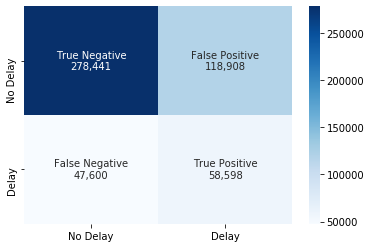

In [0]:
# Display metrics and confusion matrix
display_metrics(predictions_gbt)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel.featureImportances, train_dataset_3m_ww, "features").head(10)

Out[30]:

,idx,name,vals,score
10,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.256204
12,4,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.134142
15,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.122331
8,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.088167
5,17,TEMP,NaN,0.082564
14,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.080055
18,10,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.077827
17,9,CIG_HEIGHT_BUCKIndex,"[0.0, 1.0, __unknown]",0.062602
7,19,SLPRESS,NaN,0.049093
9,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.035060


#### Tuning

In [0]:
#Define function for tuning Gradient Boosted Tree Models

def gbt_tuning(train, validation, maxDepthVal):
  """Helper function to run various Gradient Boosted Tree models to tune hyperparamters."""
  #Create model
  gbt_tuning = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxDepth=maxDepthVal, maxIter=10, maxBins=300)
  
  #Train model with training data
  gbtModel_tuning = gbt_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = gbtModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('Max Depth:', maxDepthVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")


In [0]:
#Call function to tune
gbt_tuning(train_dataset_3m_ww, validation_dataset_3m, 6)
gbt_tuning(train_dataset_3m_ww, validation_dataset_3m, 8)

-------------------------
Max Depth: 6
AUC: 0.686
precision: 0.337
recall: 0.550
accuracy: 0.677
F1 score: 0.418
-------------------------
-------------------------
Max Depth: 8
AUC: 0.686
precision: 0.339
recall: 0.536
accuracy: 0.682
F1 score: 0.415
-------------------------

## 3 Month Data - Added features: PageRank

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "VIS_VAR"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK']

pipelineOutput_gbt_v1 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v1, validation_dataset_v1 = pipeline_fit_transform(pipelineOutput_gbt_v1, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v1_ww = class_weights_helper(train_dataset_v1)

In [0]:
#Cache prepared datasets
train_dataset_v1_ww.cache()
validation_dataset_v1.cache()

Out[87]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, VIS_VARIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v1 = gbt.fit(train_dataset_v1_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v1 = gbtModel_v1.transform(validation_dataset_v1)

AUC: 0.686
precision: 0.337
recall: 0.550
accuracy: 0.677
F1 score: 0.418

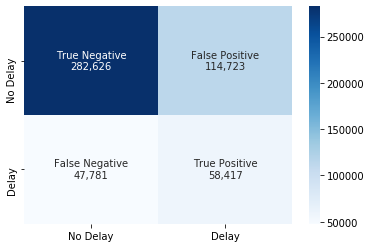

In [0]:
# Display metrics and confusion matrix
display_metrics(predictions_gbt_v1)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v1.featureImportances, train_dataset_v1_ww, "features").head(10)

Out[90]:

,idx,name,vals,score
11,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.302326
13,4,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.161522
16,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.109387
5,17,TEMP,NaN,0.088522
9,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.073741
19,10,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.057984
15,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.056861
7,19,SLPRESS,NaN,0.049529
18,9,CIG_HEIGHT_BUCKIndex,"[0.0, 1.0, __unknown]",0.049313
10,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.032064


## 3 Month Data - Added features - PageRank, Previous Flight Delay

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK']

pipelineOutput_gbt_v2 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v2, validation_dataset_v2 = pipeline_fit_transform(pipelineOutput_gbt_v2, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v2_ww = class_weights_helper(train_dataset_v2)

In [0]:
#Cache prepared datasets
train_dataset_v2_ww.cache()
validation_dataset_v2.cache()

Out[94]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, PREVIOUS_DELAYIndex: double, VIS_VARIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v2 = gbt.fit(train_dataset_v2_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v2 = gbtModel_v2.transform(validation_dataset_v2)

AUC: 0.734
precision: 0.389
recall: 0.571
accuracy: 0.721
F1 score: 0.463

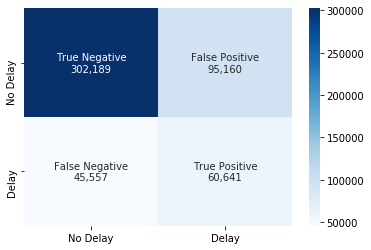

In [0]:
# Display metrics and confusion matrix
display_metrics(predictions_gbt_v2)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v2.featureImportances, train_dataset_v2_ww, "features").head(10)

Out[97]:

,idx,name,vals,score
11,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.290506
13,4,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.143870
16,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.114571
5,18,TEMP,NaN,0.086897
15,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.063768
9,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.063477
20,11,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.048929
7,20,SLPRESS,NaN,0.045387
10,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.042892
18,9,CIG_HEIGHT_BUCKIndex,"[0.0, 1.0, __unknown]",0.038080


## 3 Month Data - Added features: PageRank, Previous Flight Delay, Destination Weather

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS']

pipelineOutput_v3 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v3, validation_dataset_v3 = pipeline_fit_transform(pipelineOutput_v3, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v3_ww = class_weights_helper(train_dataset_v3)

In [0]:
#Cache prepared datasets
train_dataset_v3_ww.cache()
validation_dataset_v3.cache()

Out[101]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, PREVIOUS_DELAYIndex: double, VIS_VARIndex: double, DEST_VIS_VARIndex: double, DEST_WND_SPEED_BUCKIndex: double, DEST_VIS_DIST_BUCKIndex: double, DEST_CIG_HEIGHT_BUCKIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v3 = gbt.fit(train_dataset_v3_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v3 = gbtModel_v3.transform(validation_dataset_v3)

AUC: 0.742
precision: 0.407
recall: 0.562
accuracy: 0.735
F1 score: 0.472

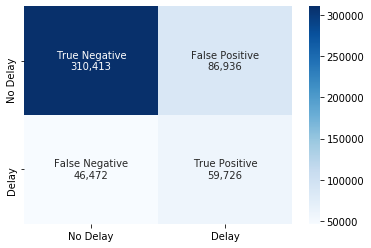

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_gbt_v3)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v3.featureImportances, train_dataset_v3_ww, "features").head(10)

Out[104]:

,idx,name,vals,score
17,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.260129
19,4,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.175941
22,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.115288
5,22,TEMP,NaN,0.066635
21,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.057584
15,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.050277
26,11,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.045216
30,15,DEST_VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.041161
25,10,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.034786
12,29,DEST_TEMP,NaN,0.034135


## 3 Month Data - Added Features: PageRank, Previous Flight Delay, Destination Weather, Flights per Day

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS', 'FLIGHTS_PER_DAY']

pipelineOutput_v4 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v4, validation_dataset_v4 = pipeline_fit_transform(pipelineOutput_v4, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v4_ww = class_weights_helper(train_dataset_v4)

In [0]:
#Cache prepared datasets
train_dataset_v4_ww.cache()
validation_dataset_v4.cache()

Out[29]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: double, DEW_TEMP: double, SLPRESS: double, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: double, DEST_DEW_TEMP: double, DEST_SLPRESS: double, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, PREVIOUS_DELAYIndex: double, VIS_VARIndex: double, DEST_VIS_VARIndex: double, DEST_WND_SPEED_BUCKIndex: double, DEST_VIS_DIST_BUCKIndex: double, DEST_CIG_HEIGHT_BUCKIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v4 = gbt.fit(train_dataset_v4_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v4 = gbtModel_v4.transform(validation_dataset_v4)

AUC: 0.723
precision: 0.342
recall: 0.655
accuracy: 0.661
F1 score: 0.449

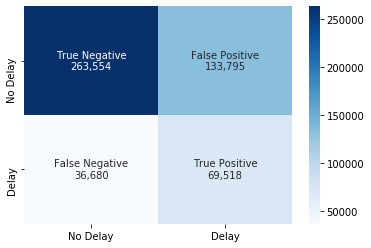

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_gbt_v4)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v4.featureImportances, train_dataset_v4_ww, "features").head(10)

Out[32]:

,idx,name,vals,score
18,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.224190
20,4,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.152680
23,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.121972
15,32,FLIGHTS_PER_DAY,NaN,0.116935
16,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.065838
22,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.051156
27,11,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.043205
5,22,TEMP,NaN,0.042920
31,15,DEST_VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.038428
17,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.034822


AUC: 0.769
precision: 0.426
recall: 0.634
accuracy: 0.732
F1 score: 0.510

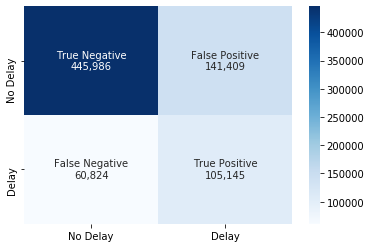

In [0]:
#check for overfitting/underfitting
predictions_on_train = gbtModel_v4.transform(train_dataset_v4_ww)
display_metrics(predictions_on_train)

# Random Forest Model - with all added features

In [0]:
# Create an initial RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxBins=312, maxDepth=8, numTrees=15)

# Train model with Training Data
rfModel_v2 = rf.fit(train_dataset_v4_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_rf_v2 = rfModel_v2.transform(validation_dataset_v4)

AUC: 0.719
precision: 0.329
recall: 0.661
accuracy: 0.644
F1 score: 0.439

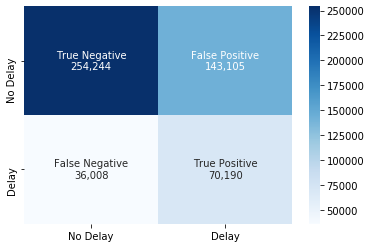

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_rf_v2)

In [0]:
#View feature importance
ExtractFeatureImp(rfModel_v2.featureImportances, train_dataset_v4_ww, "features").head(15)

Out[33]:

,idx,name,vals,score
27,11,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.212394
23,7,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.189952
22,6,FIRST_DEPIndex,"[0, 1, __unknown]",0.077944
5,22,TEMP,NaN,0.073188
15,32,FLIGHTS_PER_DAY,NaN,0.049030
17,1,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.044002
18,2,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.042272
16,0,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.031469
6,23,DEW_TEMP,NaN,0.031178
19,3,ORIGIN_STATE_ABRIndex,"[CA, TX, FL, IL, GA, NY, CO, AZ, NV, NC, VA, M...",0.030213


# Gradient Boosted Tree with top 10 Features from Random Forest Model

In [0]:
#Run data through pipeline  #######ADJUST FEATURES#########
categoricalColumns = ["PREVIOUS_DELAY", "CRS_DEP_TIME_BUCK", "FIRST_DEP", "OP_UNIQUE_CARRIER", "ORIGIN", "DAY_OF_WEEK", "DEST"]

numericCols = ["TEMP", "DEW_TEMP", "FLIGHTS_PER_DAY"]

pipelineOutput_v5 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v5, validation_dataset_v5 = pipeline_fit_transform(pipelineOutput_v5, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v5_ww = class_weights_helper(train_dataset_v5)

In [0]:
#Cache prepared datasets
train_dataset_v5_ww.cache()
validation_dataset_v5.cache()

Out[129]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, PREVIOUS_DELAYIndex: double, CRS_DEP_TIME_BUCKIndex: double, FIRST_DEPIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, DAY_OF_WEEKIndex: double, DESTIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt_v5 = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v5 = gbt_v5.fit(train_dataset_v5_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v5 = gbtModel_v5.transform(validation_dataset_v5)

AUC: 0.705
precision: 0.321
recall: 0.655
accuracy: 0.635
F1 score: 0.431

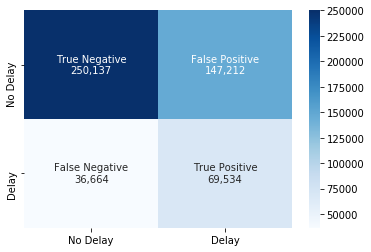

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_gbt_v5)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v5.featureImportances, train_dataset_v5_ww, "features").head(10)

Out[132]:

,idx,name,vals,score
7,4,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.228149
0,7,FLIGHTS_PER_DAY,NaN,0.162017
9,6,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.128534
4,1,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.122595
8,5,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.114875
5,2,FIRST_DEPIndex,"[0, 1, __unknown]",0.064112
1,8,TEMP,NaN,0.062022
3,0,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.050699
6,3,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.047947
2,9,DEW_TEMP,NaN,0.019051


# Gradient Boosted Tree (top 10 features from best RF model, except for flights per day)

In [0]:
#Run data through pipeline  #######ADJUST FEATURES#########
categoricalColumns = ["PREVIOUS_DELAY", "CRS_DEP_TIME_BUCK", "FIRST_DEP", "OP_UNIQUE_CARRIER", "ORIGIN", "DAY_OF_WEEK", "DEST", "ORIGIN_STATE_ABR"]

numericCols = ["TEMP", "DEW_TEMP"]

pipelineOutput_v7 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v7, validation_dataset_v7 = pipeline_fit_transform(pipelineOutput_v7, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v7_ww = class_weights_helper(train_dataset_v7)

In [0]:
#Cache prepared datasets
train_dataset_v7_ww.cache()
validation_dataset_v7.cache()

Out[39]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, PREVIOUS_DELAYIndex: double, CRS_DEP_TIME_BUCKIndex: double, FIRST_DEPIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, DAY_OF_WEEKIndex: double, DESTIndex: double, ORIGIN_STATE_ABRIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt_v7 = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v7 = gbt_v7.fit(train_dataset_v7_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v7 = gbtModel_v7.transform(validation_dataset_v7)

AUC: 0.727
precision: 0.395
recall: 0.539
accuracy: 0.729
F1 score: 0.456

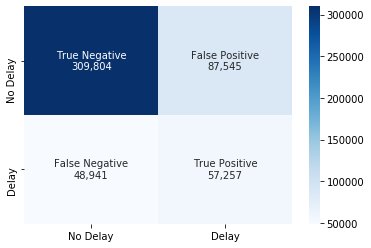

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_gbt_v7)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v7.featureImportances, train_dataset_v7_ww, "features").head(10)

Out[42]:

,idx,name,vals,score
6,4,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",0.287662
8,6,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",0.149463
3,1,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",0.146150
0,8,TEMP,NaN,0.108850
4,2,FIRST_DEPIndex,"[0, 1, __unknown]",0.079852
7,5,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",0.074796
2,0,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.061225
5,3,OP_UNIQUE_CARRIERIndex,"[WN, DL, EV, OO, AA, UA, US, MQ, B6, AS, NK, H...",0.054279
1,9,DEW_TEMP,NaN,0.037694
9,7,ORIGIN_STATE_ABRIndex,"[CA, TX, FL, IL, GA, NY, CO, AZ, NV, NC, VA, M...",0.000030


# Gradient Boosted Tree (top 10 features from best GBT model)

In [0]:
#Run data through pipeline  #######ADJUST FEATURES#########
categoricalColumns = ["PREVIOUS_DELAY", "CRS_DEP_TIME_BUCK", "FIRST_DEP", "ORIGIN", "DAY_OF_WEEK", "DEST"]

numericCols = ["TEMP", "DEST_VIS_DIST_BUCK", "VIS_DIST_BUCK", "DEST_TEMP"]

pipelineOutput_v6 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_v6, validation_dataset_v6 = pipeline_fit_transform(pipelineOutput_v6, train_data_3m, validation_data_3m)

In [0]:
#Call function to add class weights
train_dataset_v6_ww = class_weights_helper(train_dataset_v6)

In [0]:
#Cache prepared datasets
train_dataset_v6_ww.cache()
validation_dataset_v6.cache()

Out[13]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: int, DEW_TEMP: int, SLPRESS: int, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: int, DEST_DEW_TEMP: int, DEST_SLPRESS: int, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, PREVIOUS_DELAYIndex: double, CRS_DEP_TIME_BUCKIndex: double, FIRST_DEPIndex: double, ORIGINIndex: double, DAY_OF_WEEKIndex: double, DESTIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt_v6 = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=312, maxDepth=6)

# Train model with Training Data
gbtModel_v6 = gbt_v6.fit(train_dataset_v6_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_v6 = gbtModel_v6.transform(validation_dataset_v6)

AUC: 0.738
precision: 0.428
recall: 0.528
accuracy: 0.752
F1 score: 0.473

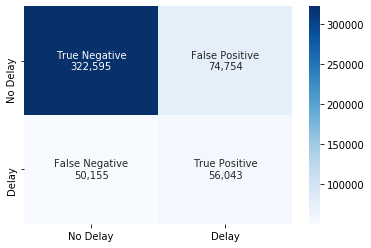

In [0]:
#Display metrics and confusion matrix
display_metrics(predictions_gbt_v6)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_v6.featureImportances, train_dataset_v6_ww, "features").head(10)

Out[17]:

,idx,name,vals,ord,score
5,3,ORIGINIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, IAH, SFO, LAS, ...",NaN,0.265214
7,5,DESTIndex,"[ATL, ORD, DFW, LAX, DEN, PHX, SFO, IAH, LAS, ...",NaN,0.205043
3,1,CRS_DEP_TIME_BUCKIndex,"[3.0, 8.0, 4.0, 6.0, 5.0, 7.0, 9.0, 10.0, 11.0...",NaN,0.141055
0,6,TEMP,NaN,NaN,0.080602
6,4,DAY_OF_WEEKIndex,"[5, 4, 3, 2, 1, 6, 7, __unknown]",NaN,0.075873
2,0,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",NaN,0.052580
4,2,FIRST_DEPIndex,"[0, 1, __unknown]",NaN,0.047381
1,9,DEST_TEMP,NaN,NaN,0.046254
8,7,DEST_VIS_DIST_BUCK,"[0.0, 16092.0, 16092.0, Infinity]",True,0.043100
9,8,VIS_DIST_BUCK,"[0.0, 16092.0, 16092.0, Infinity]",True,0.042898


### Tuning

In [0]:
#Define function for tuning Random Forest Models

def gbt_tuning(train, validation, maxDepthVal, maxIterVal, minInstancesPerNodeVal):
  
  #Create model
  gbt_tuning = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=maxIterVal, maxDepth=maxDepthVal, maxBins=312, minInstancesPerNode=minInstancesPerNodeVal)
  
  #Train model with training data
  gbtModel_tuning = gbt_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = gbtModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})
  
  #Calculate metrics
  # compute TN, TP, FN, and FP
  #predictions_tuning.groupBy('label', 'prediction').count().show()

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('Max Depth:', maxDepthVal)
  print('Max Iterations:', maxIterVal)
  print('Min Instances per Node:', minInstancesPerNodeVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")


In [0]:
#Call function to tune
#Max depth = 6, 8
#maxIter = 10, 20
#minInstancesperNode = 1, 5

#already ran 6, 10, 1 above
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 6, 10, 5)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 6, 20, 1)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 6, 20, 5)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 8, 10, 1)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 8, 10, 5)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 8, 20, 1)
gbt_tuning(train_dataset_v6_ww, validation_dataset_v6, 8, 20, 5)

-------------------------
Max Depth: 6
Max Iterations: 10
Min Instances per Node: 5
AUC: 0.738
precision: 0.428
recall: 0.528
accuracy: 0.752
F1 score: 0.473
-------------------------
-------------------------
Max Depth: 6
Max Iterations: 20
Min Instances per Node: 1
AUC: 0.745
precision: 0.445
recall: 0.527
accuracy: 0.762
F1 score: 0.482
-------------------------
-------------------------
Max Depth: 6
Max Iterations: 20
Min Instances per Node: 5
AUC: 0.744
precision: 0.446
recall: 0.524
accuracy: 0.763
F1 score: 0.482
-------------------------
-------------------------
Max Depth: 8
Max Iterations: 10
Min Instances per Node: 1
AUC: 0.737
precision: 0.433
recall: 0.525
accuracy: 0.755
F1 score: 0.474
-------------------------
-------------------------
Max Depth: 8
Max Iterations: 10
Min Instances per Node: 5
AUC: 0.738
precision: 0.432
recall: 0.527
accuracy: 0.754
F1 score: 0.475
-------------------------
-------------------------
Max Depth: 8
Max Iterations: 20
Min Instances per Node: 1
AUC: 0.740
precision: 0.441
recall: 0.523
accuracy: 0.759
F1 score: 0.478
-------------------------
-------------------------
Max Depth: 8
Max Iterations: 20
Min Instances per Node: 5
AUC: 0.740
precision: 0.441
recall: 0.520
accuracy: 0.760
F1 score: 0.478
-------------------------

# Random Forest on Full 5 Year Dataset

In [0]:
#Run data through pipeline
categoricalColumns = ["YEAR", "MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS', 'FLIGHTS_PER_DAY']

pipelineOutput_full_rf = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_full, validation_dataset_full = pipeline_fit_transform(pipelineOutput_full_rf, train_data, validation_data)

In [0]:
#Call function to add class weights
train_dataset_full_ww = class_weights_helper(train_dataset_full)

In [0]:
#Cache prepared datasets
train_dataset_full_ww.cache()
validation_dataset_full.cache()

Out[20]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: double, DEW_TEMP: double, SLPRESS: double, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: double, DEST_DEW_TEMP: double, DEST_SLPRESS: double, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, YEARIndex: double, MONTHIndex: double, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, PREVIOUS_DELAYIndex: double, VIS_VARIndex: double, DEST_VIS_VARIndex: double, DEST_WND_SPEED_BUCKIndex: double, DEST_VIS_DIST_BUCKIndex: double, DEST_CIG_HEIGHT_BUCKIndex: double, label: double, features: vector]

In [0]:
# Create an initial RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxDepth=8, numTrees=15, maxBins=316)

# Train model with Training Data
rfModel_full = rf.fit(train_dataset_full_ww)

# Make predictions on validation data using the Transformer.transform() method.
predictions_rf_full = rfModel_full.transform(validation_dataset_full)

AUC: 0.691
precision: 0.321
recall: 0.561
accuracy: 0.679
F1 score: 0.408

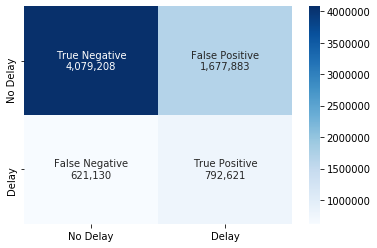

In [0]:
display_metrics(predictions_rf_full)

In [0]:
#View feature importance
ExtractFeatureImp(rfModel_full.featureImportances, train_dataset_full_ww, "features").head(10)

Out[23]:

,idx,name,vals,score
29,13,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.399844
25,9,CRS_DEP_TIME_BUCKIndex,"[3.0, 4.0, 8.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0...",0.187016
24,8,FIRST_DEPIndex,"[0, 1, __unknown]",0.114911
17,1,MONTHIndex,"[7, 8, 6, 10, 3, 5, 9, 4, 11, 12, 1, 2, __unkn...",0.045593
19,3,OP_UNIQUE_CARRIERIndex,"[WN, DL, AA, OO, UA, EV, B6, AS, NK, F9, MQ, H...",0.032365
5,24,TEMP,NaN,0.031807
32,16,DEST_WND_SPEED_BUCKIndex,"[2.0, 1.0, 0.0, 3.0, __unknown]",0.029017
21,5,ORIGIN_STATE_ABRIndex,"[CA, TX, FL, GA, IL, NY, CO, AZ, NV, NC, VA, M...",0.018338
22,6,DESTIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.016986
15,34,FLIGHTS_PER_DAY,NaN,0.016916


# Gradient Boosted Tree on Full 5 Year Dataset

In [0]:
#Run data through pipeline ###ADJUST FEATURES####
categoricalColumns = ["YEAR", "MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]

numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS']

pipelineOutput_full_gbt = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_full_gbt, validation_dataset_full_gbt = pipeline_fit_transform(pipelineOutput_full_gbt, train_data, validation_data)

In [0]:
#Call function to add class weights
train_dataset_full_ww_gbt = class_weights_helper(train_dataset_full_gbt)

In [0]:
#Cache prepared datasets
train_dataset_full_ww_gbt.cache()
validation_dataset_full_gbt.cache()

Out[39]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: double, DEW_TEMP: double, SLPRESS: double, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: double, DEST_DEW_TEMP: double, DEST_SLPRESS: double, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, YEARIndex: double, MONTHIndex: double, DAY_OF_WEEKIndex: double, OP_UNIQUE_CARRIERIndex: double, ORIGINIndex: double, ORIGIN_STATE_ABRIndex: double, DESTIndex: double, DEST_STATE_ABRIndex: double, FIRST_DEPIndex: double, CRS_DEP_TIME_BUCKIndex: double, WND_SPEED_BUCKIndex: double, CIG_HEIGHT_BUCKIndex: double, VIS_DIST_BUCKIndex: double, PREVIOUS_DELAYIndex: double, VIS_VARIndex: double, DEST_VIS_VARIndex: double, DEST_WND_SPEED_BUCKIndex: double, DEST_VIS_DIST_BUCKIndex: double, DEST_CIG_HEIGHT_BUCKIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=316)

# Train model with Training Data
gbtModel_full = gbt.fit(train_dataset_full_ww_gbt)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_full = gbtModel_full.transform(validation_dataset_full_gbt)

AUC: 0.706
precision: 0.332
recall: 0.571
accuracy: 0.689
F1 score: 0.420

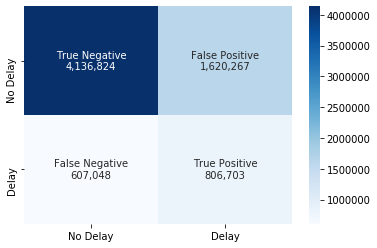

In [0]:
display_metrics(predictions_gbt_full)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_full.featureImportances, train_dataset_full_ww_gbt, "features").head(10)

Out[42]:

,idx,name,vals,score
28,13,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.171199
24,9,CRS_DEP_TIME_BUCKIndex,"[3.0, 4.0, 8.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0...",0.159157
19,4,ORIGINIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.140765
16,1,MONTHIndex,"[7, 8, 6, 10, 3, 5, 9, 4, 11, 12, 1, 2, __unkn...",0.086951
21,6,DESTIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.075548
5,24,TEMP,NaN,0.066256
23,8,FIRST_DEPIndex,"[0, 1, __unknown]",0.056135
27,12,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.050965
18,3,OP_UNIQUE_CARRIERIndex,"[WN, DL, AA, OO, UA, EV, B6, AS, NK, F9, MQ, H...",0.042926
26,11,CIG_HEIGHT_BUCKIndex,"[1.0, 0.0, __unknown]",0.028266


# Gradient Boosted Tree on Full 5 Year Dataset - 10 best features from GBT

In [0]:
#Run data through pipeline ###ADJUST FEATURES####
categoricalColumns = ["PREVIOUS_DELAY",  "CRS_DEP_TIME_BUCK", "ORIGIN", "MONTH", "DEST", "FIRST_DEP", "VIS_DIST_BUCK", "OP_UNIQUE_CARRIER"]

numericCols = ['TEMP', 'FLIGHTS_PER_DAY']

pipelineOutput_full_gbt_v2 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_full_gbt_v2, validation_dataset_full_gbt_v2 = pipeline_fit_transform(pipelineOutput_full_gbt_v2, train_data, validation_data)

In [0]:
#Call function to add class weights
train_dataset_full_ww_gbt_v2 = class_weights_helper(train_dataset_full_gbt_v2)

In [0]:
#Cache prepared datasets
train_dataset_full_ww_gbt_v2.cache()
validation_dataset_full_gbt_v2.cache()

Out[106]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: double, DEW_TEMP: double, SLPRESS: double, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: double, DEST_DEW_TEMP: double, DEST_SLPRESS: double, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, PREVIOUS_DELAYIndex: double, CRS_DEP_TIME_BUCKIndex: double, ORIGINIndex: double, MONTHIndex: double, DESTIndex: double, FIRST_DEPIndex: double, VIS_DIST_BUCKIndex: double, OP_UNIQUE_CARRIERIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=316)

# Train model with Training Data
gbtModel_full_v2 = gbt.fit(train_dataset_full_ww_gbt_v2)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_full_v2 = gbtModel_full_v2.transform(validation_dataset_full_gbt_v2)

AUC: 0.698
precision: 0.316
recall: 0.594
accuracy: 0.667
F1 score: 0.413

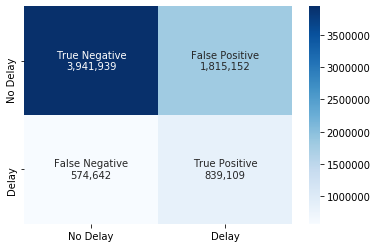

In [0]:
display_metrics(predictions_gbt_full_v2)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_full_v2.featureImportances, train_dataset_full_ww_gbt_v2, "features").head(10)

Out[109]:

,idx,name,vals,score
3,1,CRS_DEP_TIME_BUCKIndex,"[3.0, 4.0, 8.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0...",0.184402
2,0,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.179772
4,2,ORIGINIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.140685
5,3,MONTHIndex,"[7, 8, 6, 10, 3, 5, 9, 4, 11, 12, 1, 2, __unkn...",0.098303
1,9,FLIGHTS_PER_DAY,NaN,0.075235
0,8,TEMP,NaN,0.073913
6,4,DESTIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.069535
7,5,FIRST_DEPIndex,"[0, 1, __unknown]",0.067337
8,6,VIS_DIST_BUCKIndex,"[1.0, 0.0, __unknown]",0.061573
9,7,OP_UNIQUE_CARRIERIndex,"[WN, DL, AA, OO, UA, EV, B6, AS, NK, F9, MQ, H...",0.049245


# Gradient Boosted Tree on Full dataset - 10 best features from RF

In [0]:
#Run data through pipeline ###ADJUST FEATURES####
categoricalColumns = ["PREVIOUS_DELAY",  "CRS_DEP_TIME_BUCK", "MONTH", "DEST", "FIRST_DEP",  "OP_UNIQUE_CARRIER", "DEST_WND_SPEED_BUCK", "ORIGIN_STATE_ABR"]

numericCols = ['TEMP', 'FLIGHTS_PER_DAY']

pipelineOutput_full_gbt_v3 = pipeline_helper(categoricalColumns, numericCols)

In [0]:
#Fit and transform data using pipeline
train_dataset_full_gbt_v3, validation_dataset_full_gbt_v3 = pipeline_fit_transform(pipelineOutput_full_gbt_v3, train_data, validation_data)

In [0]:
#Call function to add class weights
train_dataset_full_ww_gbt_v3 = class_weights_helper(train_dataset_full_gbt_v3)

In [0]:
#Cache prepared datasets
train_dataset_full_ww_gbt_v3.cache()
validation_dataset_full_gbt_v3.cache()

Out[27]: DataFrame[YEAR: string, MONTH: string, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME_BUCK: double, CRS_ELAPSED_TIME: double, DISTANCE: double, FIRST_DEP: int, PREVIOUS_DELAY: int, FLIGHTS_PER_DAY: bigint, LATITUDE: double, LONGITUDE: double, ELEVATION: double, WND_SPEED_BUCK: double, CIG_HEIGHT_BUCK: double, VIS_DIST_BUCK: double, VIS_VAR: string, TEMP: double, DEW_TEMP: double, SLPRESS: double, PAGERANK: double, DEST_LATITUDE: double, DEST_LONGITUDE: double, DEST_ELEVATION: double, DEST_VIS_VAR: string, DEST_TEMP: double, DEST_DEW_TEMP: double, DEST_SLPRESS: double, DEST_WND_SPEED_BUCK: double, DEST_VIS_DIST_BUCK: double, DEST_CIG_HEIGHT_BUCK: double, DELAY: string, PREVIOUS_DELAYIndex: double, CRS_DEP_TIME_BUCKIndex: double, MONTHIndex: double, DESTIndex: double, FIRST_DEPIndex: double, OP_UNIQUE_CARRIERIndex: double, DEST_WND_SPEED_BUCKIndex: double, ORIGIN_STATE_ABRIndex: double, label: double, features: vector]

In [0]:
#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxBins=316)

# Train model with Training Data
gbtModel_full_v3 = gbt.fit(train_dataset_full_ww_gbt_v3)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_full_v3 = gbtModel_full_v3.transform(validation_dataset_full_gbt_v3)

AUC: 0.693
precision: 0.317
recall: 0.580
accuracy: 0.670
F1 score: 0.410

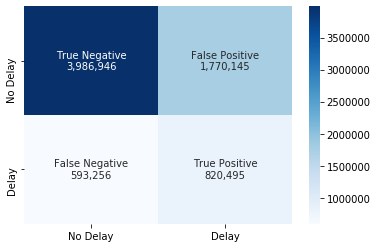

In [0]:
display_metrics(predictions_gbt_full_v3)

In [0]:
#View feature importance
ExtractFeatureImp(gbtModel_full_v3.featureImportances, train_dataset_full_ww_gbt_v3, "features").head(10)

Out[30]:

,idx,name,vals,score
3,1,CRS_DEP_TIME_BUCKIndex,"[3.0, 4.0, 8.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0...",0.201130
2,0,PREVIOUS_DELAYIndex,"[0, 1, __unknown]",0.194170
4,2,MONTHIndex,"[7, 8, 6, 10, 3, 5, 9, 4, 11, 12, 1, 2, __unkn...",0.115105
9,7,ORIGIN_STATE_ABRIndex,"[CA, TX, FL, GA, IL, NY, CO, AZ, NV, NC, VA, M...",0.114492
1,9,FLIGHTS_PER_DAY,NaN,0.081911
6,4,FIRST_DEPIndex,"[0, 1, __unknown]",0.076759
0,8,TEMP,NaN,0.070995
5,3,DESTIndex,"[ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ...",0.069023
7,5,OP_UNIQUE_CARRIERIndex,"[WN, DL, AA, OO, UA, EV, B6, AS, NK, F9, MQ, H...",0.065161
8,6,DEST_WND_SPEED_BUCKIndex,"[2.0, 1.0, 0.0, 3.0, __unknown]",0.011253


## Tuning

In [0]:
#Define function for tuning Random Forest Models

def gbt_tuning(train, validation, maxDepthVal, maxBinsVal, minInstancesPerNodeVal):
  
  #Create model
  gbt_tuning = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxIter=10, maxDepth=maxDepthVal, maxBins=maxBinsVal, minInstancesPerNode=minInstancesPerNodeVal)
  
  #Train model with training data
  gbtModel_tuning = gbt_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = gbtModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})
  
  #Calculate metrics
  # compute TN, TP, FN, and FP
  #predictions_tuning.groupBy('label', 'prediction').count().show()

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('Max Depth:', maxDepthVal)
  print('Max Bins:', maxBinsVal)
  print('Min Instances per Node:', minInstancesPerNodeVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")

In [0]:
#Call function to tune
#maxdepth = 6, 8
#maxbins = 20, 60
#minInstancesperNode = 1, 5
gbt_tuning(training_dataset_DT, validation_dataset_DT, 10, 40, 1)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 8, 40, 1)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 10, 60, 1)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 8, 60, 1)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 10, 40, 5)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 8, 40, 5)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 10, 60, 5)
gbt_tuning(training_dataset_DT, validation_dataset_DT, 8, 60, 5)

# Gradient Boosted Tree - 3 month data with PCA

AUC: 0.742
precision: 0.388
recall: 0.608
accuracy: 0.715
F1 score: 0.474

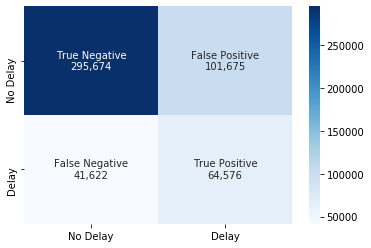

In [0]:
#Create a vector of the numeric columns that need standardization
#Define numeric columns
numericalColumns = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS']
#Define input column names that VectorAssembler will take and combine into one vector with the specified output column name
numericalCols_vector = VectorAssembler(inputCols=numericalColumns, outputCol="numerical_features")
#Define the stage for the pipeline
stages_standardize = [numericalCols_vector]

#Run pipeline to create vector of numeric columns in training data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(train_data_3m)
trainingData_standardize_vector = pipelineModel_standardize.transform(train_data_3m)

#Run pipeline to create vector of numeric columns in validation data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(validation_data_3m)
validationData_standardize_vector = pipelineModel_standardize.transform(validation_data_3m)

#Standardize training data - fit and transform
Scalerizer = StandardScaler(inputCol="numerical_features", outputCol="standardized_features", withStd=True, withMean=True)
trainingData_standards = Scalerizer.fit(trainingData_standardize_vector)
trainingData_standardized = trainingData_standards.transform(trainingData_standardize_vector)

#Standardize validation data - transform
validationData_standardized = trainingData_standards.transform(validationData_standardize_vector)

#Perform PCA on the numeric features
pca = PCA(k=10, inputCol="standardized_features", outputCol="pcaFeatures")
pca_model = pca.fit(trainingData_standardized)
train_dataset_pca = pca_model.transform(trainingData_standardized)
validation_dataset_pca = pca_model.transform(validationData_standardized)

#Run data through pipeline to assemble vector of categorical columns and PCA features
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]
numericCols = ["pcaFeatures"]
pipelineOutput = pipeline_helper(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset_pca_final, validation_dataset_pca_final = pipeline_fit_transform(pipelineOutput, train_dataset_pca, validation_dataset_pca)

#Call function to add class weights
train_dataset_pca_ww = class_weights_helper(train_dataset_pca_final)

#Cache prepared datasets
train_dataset_pca_ww.cache()
validation_dataset_pca_final.cache()

#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxBins=316, maxDepth=6)

#Train model with training data
gbtModel = gbt.fit(train_dataset_pca_ww)

#Make predictions on validation data using the Transformer.transform() method.
predictions_gbt = gbtModel.transform(validation_dataset_pca_final)

#Display metrics and confusion matrix
display_metrics(predictions_gbt)

#Get feature importance
ExtractFeatureImp(gbtModel.featureImportances, train_dataset_pca_ww, "features").head(10)

#Get feature importance for PCA features
pc_df = pd.DataFrame(data=pca_model.pc.toArray(), index=['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS'])

In [0]:
#Call function to tune
#maxdepth = 6, 8
#maxbins = 316
#minInstancesperNode = 1, 5
#gbt_tuning(train_dataset_pca_ww, validation_dataset_pca_final, 6, 316, 1)
gbt_tuning(train_dataset_pca_ww, validation_dataset_pca_final, 8, 316, 1)
#gbt_tuning(train_dataset_pca_ww, validation_dataset_pca_final, 10, 316, 1)